In [1]:
# Load the Excel file
file_path = "All Data.xlsx"

C:\Users\milan\AppData\Local\Temp\ipykernel_26428\3711877430.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)
16:37:34 - cmdstanpy - INFO - Chain [1] start processing



Using Prophet to forecast...


16:37:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\milan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Forecasted Data:
           ds         yhat   yhat_lower    yhat_upper
46 2021-01-01  2999.226013 -3443.377253   8876.273710
47 2022-01-01  3201.153738 -2576.667021   9345.912263
48 2023-01-01  3480.204247 -2476.814696   9491.249338
49 2024-01-01  3836.074193 -1881.504469  10178.858901
50 2024-12-31  4268.326689 -1695.306888  10173.104203
Prophet Forecast Results:
Forecast = 4268.33, 95% Confidence Interval: [0.00, 10173.10]
MAE = 1518.33, RMSE = 1518.33


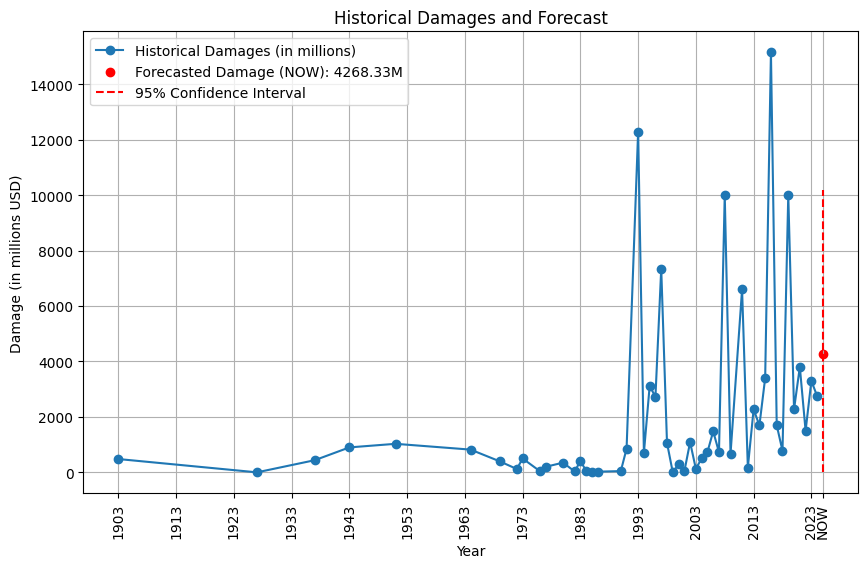

In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import warnings
import matplotlib.pyplot as plt

# Load the Excel file containing the data
def load_data(file_path):
    try:
        return pd.read_excel(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

# Preprocessing function 
def preprocess_data(data, country, disaster_type):
    filtered_data = data[(data['ISO'] == country.upper()) &
                         (data['Disaster Type'] == disaster_type)]
    if filtered_data.empty:
        return None

    filtered_data['Year'] = filtered_data['DisNo.'].str[:4].astype(int)
    historical_data = filtered_data[['Year', 'Total Damage (\'000 US$)']].dropna()
    
    # Convert to millions and aggregate by year
    historical_data['Total Damage (Millions)'] = historical_data['Total Damage (\'000 US$)'] / 1_000
    historical_data = historical_data.groupby('Year', as_index=False)['Total Damage (Millions)'].sum()
    
    historical_data.rename(columns={'Year': 'ds', 'Total Damage (Millions)': 'y'}, inplace=True)
    return historical_data

# Prophet forecast function
def forecast_damage_prophet(historical_data):
    try:
        # Ensure data is correctly formatted for Prophet
        historical_data['ds'] = pd.to_datetime(historical_data['ds'], format='%Y')

        # Initialize and configure the Prophet model with 95% CI
        model = Prophet(interval_width=0.95)
        model.fit(historical_data)

        # Create future dataframe
        future = model.make_future_dataframe(periods=1, freq='Y')

        # Forecast the next value
        forecast = model.predict(future)

        # Debugging outputs
        print("Forecasted Data:")
        print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

        forecasted_value = forecast.iloc[-1]['yhat']
        lower = max(0, forecast.iloc[-1]['yhat_lower'])  
        upper = forecast.iloc[-1]['yhat_upper']
        return round(forecasted_value, 2), round(lower, 2), round(upper, 2), model
    except Exception as e:
        return f"Prophet model fitting failed: {e}", None, None, None

# Evaluate model performance
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error([y_true], [y_pred])
    rmse = sqrt(mean_squared_error([y_true], [y_pred]))
    return mae, rmse

# Forecast function
def forecast_damage(data, country, disaster_type):
    historical_data = preprocess_data(data, country, disaster_type)
    if historical_data is None:
        print(f"No historical data available for {disaster_type} in {country}.")
        return

    print("\nUsing Prophet to forecast...")

    prophet_forecast, lower, upper, model = forecast_damage_prophet(historical_data)
    if isinstance(prophet_forecast, str):
        print(prophet_forecast)
        return

    # Evaluate the model
    last_value = historical_data['y'].iloc[-1]
    mae, rmse = evaluate_model(last_value, prophet_forecast)

    print("Prophet Forecast Results:")
    print(f"Forecast = {prophet_forecast:.2f}, 95% Confidence Interval: [{lower:.2f}, {upper:.2f}]")
    print(f"MAE = {mae:.2f}, RMSE = {rmse:.2f}")

    plot_forecast(historical_data, prophet_forecast, lower, upper)

# Plot function with 95% CI 
def plot_forecast(historical_data, forecasted_value, lower, upper):
    next_year = historical_data['ds'].iloc[-1].year + 1

    plt.figure(figsize=(10, 6))
    plt.plot(historical_data['ds'], historical_data['y'], label="Historical Damages (in millions)", marker='o')
    plt.scatter(pd.Timestamp(next_year, 1, 1), forecasted_value, color='red', label=f"Forecasted Damage (NOW): {forecasted_value:.2f}M")
    plt.vlines(x=pd.Timestamp(next_year, 1, 1), ymin=lower, ymax=upper, colors='red', linestyles='--', label='95% Confidence Interval')

    plt.title("Historical Damages and Forecast")
    plt.xlabel("Year")
    plt.ylabel("Damage (in millions USD)")
    plt.legend()
    plt.grid()

    year_ticks = list(range(historical_data['ds'].dt.year.min(), next_year + 1, 10)) + [next_year]
    year_labels = [str(year) for year in year_ticks[:-1]] + ['NOW']

    plt.xticks(pd.to_datetime([f"{year}-01-01" for year in year_ticks]), labels=year_labels, rotation=90)
    plt.show()

# Main program
if __name__ == "__main__":
    file_path = "All Data.xlsx"
    data = load_data(file_path)
    if data is not None:
        country = input("Enter the country (ISO code, e.g., 'USA'): ").strip().upper()
        disaster_type = input("Enter the disaster type (e.g., 'Storm'): ").strip()
        forecast_damage(data, country, disaster_type)
